In [6]:
import configparser
from pathlib import Path
import pandas as pd
import pandas.io.sql as pandasql
from psycopg2 import connect
import numpy
from psycopg2.extras import execute_values
from datetime import datetime
import matplotlib as mpl
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
import copy
import matplotlib.ticker as ticker
from setuptools import setup, find_packages
from math import factorial
from simanneal import Annealer
from itertools import islice 
import matplotlib.patches as patches
CONFIG = configparser.ConfigParser()
CONFIG.read(str(Path.home().joinpath('db.cfg')))
from itertools import combinations, chain
dbset = CONFIG['DBSETTINGS']
con = connect(**dbset)

## Greedy forward partitioning

In [160]:
merged = pd.read_sql('''select * from congestion.merged_segments_v2 where length >200
''',con)

In [161]:
def handle_subsection(subsection, prev_i, max_segment_length=250.):
    # Scans through each subsection of `lengths`, grouping together
    # segments up to `max_segment_length`.
    subsec_segments = [{'idx': [prev_i, ], 'length': subsection[0]}]

    if len(subsection) > 1:
        for i, item in enumerate(subsection[1:]):
            if subsec_segments[-1]['length'] + item < max_segment_length or (i== 0 and subsec_segments[0]['length'] < 100):
                subsec_segments[-1]['idx'].append(i + prev_i + 1)
                subsec_segments[-1]['length'] += item
            elif subsec_segments[-1]['length'] + item > max_segment_length:
                subsec_segments.append({'idx': [i + prev_i + 1, ], 'length': item})
    return subsec_segments

In [ ]:
# forward partition
max_multi_length = 250.
min_segment_length = 100.
for index, row in merged.iterrows():
    segment_id = merged['segment_id'].iloc[index].astype(float)
    lengths = merged['length_set'].iloc[index]
    link_dir = merged['link_set'].iloc[index]    
    segments = []
    segments.extend(handle_subsection(lengths, 0))
    segments = sorted(segments, key=lambda x: x['idx'][0])
    too_small = [i for i in range(len(segments)) if segments[i]['length'] < 100]
    n_deleted = 0

    for ir in too_small:
        i = ir - n_deleted
        if i == 0:
            segments[1]['idx'] = segments[i]['idx'] + segments[1]['idx']
            segments[1]['length'] += segments[i]['length']
        elif i == len(segments) - 1:
            segments[-2]['idx'] += segments[i]['idx']
            segments[-2]['length'] += segments[i]['length']
        else:
            if segments[i - 1]['length'] >= segments[i + 1]['length']:
                segments[i + 1]['idx'] = segments[i]['idx'] + segments[i + 1]['idx']
                segments[i + 1]['length'] += segments[i]['length']
            else:
                segments[i - 1]['idx'] += segments[i]['idx']
                segments[i - 1]['length'] += segments[i]['length']
        del segments[i]
        n_deleted += 1
    rows = []
    for i in range(len(segments)):
        id = i
        new_length = segments[i]['length']
        link_set = []
        for i in segments[i]['idx']:
            link_set.append(link_dir[i])
        row = (segment_id, id, link_set, new_length)
        rows.append(row) 
    sql = '''insert into congestion.test_pythonmerge_probs(segment_id, id, link_set, length) VALUES %s'''    
    with con:
        with con.cursor() as cur:
            execute_values(cur, sql, rows)

## Best Group

In [3]:
small_groups = pd.read_sql('''with sets as (
select * from congestion.merged_segments_v2 inner join 
(select distinct segment_id from congestion.partition_result)long using (segment_id))

, int as (select  *, unnest(length_set) as lengths, array_length(length_set, 1) from sets
where array_length(length_set, 1) <=30 and array_length(length_set, 1) >2   order by array_length(length_set, 1))
select segment_id, start_vid, end_vid, link_set,array_agg(lengths::int order by row_number) as length_set, length
from (select row_number() over (), * from int)a	 where segment_id in (76,105)
group by segment_id, start_vid, end_vid, link_set, length	

                                ''',con)

Text(0, 0.5, 'Number of segments')

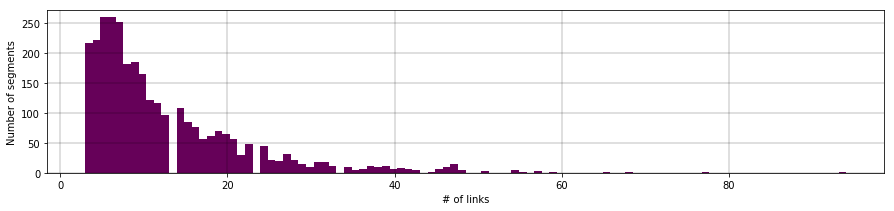

In [4]:

class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''with sets as (
                        select * from congestion.merged_segments_v2 inner join 
                        (select distinct segment_id from congestion.partition_result)long
                        using (segment_id))
                        select array_length(length_set, 1) as length from sets where array_length(length_set, 1) > 2 ''',con)
plt.figure(figsize=(15,3))
plt.hist(duration_freq.length, bins=100, color = colour.purple)
axes = plt.gca()
axes.set_facecolor('xkcd:white')
axes.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('# of links')
plt.ylabel('Number of segments')    

In [4]:
def get_num_groups(length_set, length):
    num_link = len(length_set)
    long_link = 0
    for i in length_set:
        if i >200:
            long_link = long_link + 1
    groups = 1+ int(length/200) + long_link
    start = int(length/200)
    if groups > num_link:
        groups = num_link
    else: 
        groups = groups
    if start > groups:
        start = num_link-2
    else:
        start = start
        
    if start == 1 or start == 0:
        range = [1, groups]
    else:
        range = [start-1 , groups]
    return num_link, range

def calculate_num_combination(num_link, range1):
    total_com = 0
    for i in range(range1[0], range1[1]):
        print(i)
        x = num_link - 1
        y = i - 1
        com = factorial(x)/(factorial(y)*factorial(x-y))
        total_com = total_com + com
    return total_com    

def split_list(data, n):
    for splits in combinations(range(1, len(data)), n-1):
        result = []
        prev = None
        for split in chain(splits, [None]):
            result.append(data[prev:split])
            prev = split
        yield result
        
def return_results(length_set, groups):
    possibility = []
    for q in range(groups[0], groups[1]):
        split_result = split_list(length_set, q)
        for a in split_result:  
            possibility.append(a)           
    group_result = []
    group_set = []
    for groups in possibility:
        result = []
        sets = []
        for set in groups:
            sum_length = sum(set)
            result.append(sum_length)
            sets.append(set)
        group_result.append(result) 
        group_set.append(sets)
    return group_result, group_set        

def evaluate_results(return_groups):
    set_result = []
    for set in return_groups:
        sum_diff = 0
        for i in range(len(set)):
            diff = abs(200-set[i])
            sum_diff = sum_diff + diff
        set_result.append(sum_diff)  
    selection = set_result.index(min(set_result))
    return selection

def find_link(group_set, selection):
    length_to_split = []
    for i in group_set[selection]:
         length_to_split.append(len(i))

    Input = iter(link_dir) 
    split_link = [list(islice(Input, elem)) 
              for elem in length_to_split] 
    return split_link, group_set[selection]

In [55]:
rows = []

for index, row in small_groups.iterrows():
    now = datetime.now()
    row = []
    groups = None
    length_set = small_groups['length_set'].iloc[index]
    link_dir = small_groups['link_set'].iloc[index] 
    segment_id = small_groups['segment_id'].iloc[index].astype(float)
    length = small_groups['length'].iloc[index].astype(float)
    print('Segment ID: ' + str(segment_id))
    # Get number of dividing groups based on length and number of links
    num_link, groups = get_num_groups(length_set, length)
    print(groups)
    num_group = calculate_num_combination(num_link, groups)

    if num_group <= 15000000:
        print(num_group)
        # Return divided group set
        return_groups, group_set = return_results(length_set, groups)
        # Make selection based on summed length
        selection = evaluate_results(return_groups)

        done = datetime.now()
        print(done-now)

        # Retrieve selected partitioned array
        result_link, result_length = find_link(group_set, selection)
        return_groups = []
        group_set = []
        # Prepare rows for sql inserting
        for i in range(len(result_link)):
            new_link_set = result_link[i]
            new_length = sum(result_length[i]) 
            new_length_set = result_length[i]
            row = (segment_id, i, new_link_set, new_length_set, new_length)
            rows.append(row)             
       
sql = '''insert into congestion.partition_all_possibility_v2(segment_id, id, link_set, length_set, length) VALUES %s'''    
with con:
    with con.cursor() as cur:
        execute_values(cur, sql, rows)     

Segment ID: 76.0
[1, 3]
1
2
9.0
9
[[[57, 10, 64, 47, 20, 89, 59, 45, 82]], [[57], [10, 64, 47, 20, 89, 59, 45, 82]], [[57, 10], [64, 47, 20, 89, 59, 45, 82]], [[57, 10, 64], [47, 20, 89, 59, 45, 82]], [[57, 10, 64, 47], [20, 89, 59, 45, 82]], [[57, 10, 64, 47, 20], [89, 59, 45, 82]], [[57, 10, 64, 47, 20, 89], [59, 45, 82]], [[57, 10, 64, 47, 20, 89, 59], [45, 82]], [[57, 10, 64, 47, 20, 89, 59, 45], [82]]]
0:00:00.001680
Segment ID: 105.0
[1, 2]
1
1.0
1
[[[44, 33, 16, 18, 13, 53, 76, 54]]]
0:00:00.000830
0:00:00.003778


## Simulated annealing

In [3]:
anneal = pd.read_sql('''with sets as (
                        select * from congestion.merged_segments_v2 inner join 
                        (select distinct segment_id from congestion.partition_result)long
                        using (segment_id))
                        select * from sets
                        where array_length(length_set, 1) >=20 ''',con)

In [7]:
class LineSegment:
    """Line segment information."""
    
    def __init__(self, id, length):
        self._id = id
        self._length = length
    
    @property
    def id(self):
        return self._id
    
    @property
    def length(self):
        return self._length
    
    def __repr__(self):
        return "{0}: {1}".format(self._id, self._length)

In [8]:
def get_n_part(corridor, d=200.):
    """Get recommended number of partitions for a corridor, following
    the equation above.
    
    Parameters
    ----------
    corridor : list
        List of corridor lengths.
    d : float
        Maximum length of subdivision.
    """
    c = np.array(corridor) 
    return np.sum(c > d) + np.sum(c[c <= d]) / d

In [9]:
def part_total_length(part):
    return sum([l.length for l in part])

In [10]:
class SegmentPartitionProblem(Annealer):
    """Attempt at solving the partitioning problem with simulated annealing."""

    def __init__(self, corridor, d=200., metric=metrics.mean_squared_error):
        self.d = d
        self.metric = metric
        
        if len(corridor) < 2:
            raise ValueError("corridor has too few elements to optimize.")
        state = self.greedy_partitioning(corridor)
        # Feed initial state to the Annealer.
        super().__init__(state)

    @staticmethod
    def part_total_length(part):
        return sum([l.length for l in part])

    def greedy_partitioning(self, corridor):
        """Greedy algorithm to partition corridor.

        Moving from left to right, growth partitions with
        corridor segments until its length is greater than `d`.
        """
        # Start by populating the first partition.
        partitions = []
        partitions.append([LineSegment(0, corridor[0])])

        # Cycling through line segments...
        for i_, item in enumerate(corridor[1:]):
            # Since we're starting at corridor[1].
            i = i_ + 1
            # If partition's getting too large, start a new partition.
            if (part_total_length(partitions[-1]) + item) > self.d:
                partitions.append([LineSegment(i, item)])
            # Otherwise append to current partition.
            else:
                partitions[-1].append(LineSegment(i, item))

        return partitions

    def move(self):
        """Randomly move a boundary line segment from one partition to another."""
        idx = np.random.randint(0, len(self.state))
        ismoveleft = bool(np.random.randint(0, 2))
        self.move_segment(idx, ismoveleft)

    def move_segment(self, idx, ismoveleft):
        """Move a boundary line segment from one partition to another.

        Boundary line segments are the first or last segments within
        a partition.  It is only possible to move the left boundary segment
        (the first segment in the list) leftward, or the right boundary
        segment (last segment in the list) rightward.

        It's possible to move the first segment left or the last segment right;
        new self.state are made in those cases.  If a partition is completely
        empty after the move, it is deleted.

        Parameters
        ----------
        idx : int
            Index of partition for move.
        ismoveleft : bool
            If True, move first boundary segment left; otherwise move last
            boundary segment right.
        """
        # If the left boundary segment of the first partition is to be moved
        # create a new partition.  If there's only one element in the first
        # partition, do nothing, since it's equivalent to creating a new
        # partition and deleting the old one.
        if idx == 0 and ismoveleft:
            if len(self.state[0]) > 1:
                mpart = self.state[0][0]
                del self.state[0][0]
                self.state.insert(0, [mpart, ])
        # Same logic as before, except for right boundary segment of the
        # final partition.
        elif idx == (len(self.state) - 1) and not ismoveleft:
            if len(self.state[-1]) > 1:
                mpart = self.state[-1][-1]
                del self.state[-1][-1]
                self.state.append([mpart, ])
        # Otherwise we're dealing with moving an element in the middle.
        else:
            # If we're moving the left boundary segment leftward.
            if ismoveleft:
                mpart = self.state[idx][0]
                del self.state[idx][0]
                self.state[idx - 1].append(mpart)
                if not len(self.state[idx]):
                    del self.state[idx]
            # Otherwise move the right boundary segment rightward.
            else:
                mpart = self.state[idx][-1]
                del self.state[idx][-1]
                self.state[idx + 1].insert(0, mpart)
                if not len(self.state[idx]):
                    del self.state[idx]

    def energy(self):
        """Calculate error between each partition's total length and its expected
        total length."""
        total_lengths = np.array(
            [part_total_length(part) for part in self.state])
        expected_lengths = self.d * np.ones_like(total_lengths)
        return self.metric(expected_lengths, total_lengths)

In [11]:
rows = []
for index, row in anneal.iterrows():
    corridor = anneal['length_set'].iloc[index]
    links = anneal['link_set'].iloc[index]
    segment_id = anneal['segment_id'].iloc[index].astype(float)

    solver = SegmentPartitionProblem(corridor)
    solver.steps = 50000
    solver.anneal()
    solver_comp = SegmentPartitionProblem(corridor)
    result = solver.best_state

    for i in range(len(result)):
        new_length_set = []
        new_link_set = []    
        for a in result[i]:       
            new_link_set.append(links[a._id])
            length = a._length
            new_length_set.append(length)
        new_length = sum(new_length_set)
        row = (segment_id, i, new_link_set, new_length_set, new_length)
        rows.append(row)        

sql = '''insert into congestion.partition_simanneal(segment_id, id, link_set, length_set, length) VALUES %s'''    
with con:
    with con.cursor() as cur:
        execute_values(cur, sql, rows)   

 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000       7941.52     0.80%     0.40%     0:01:27     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000      30339.98     2.40%     0.00%     0:01:01     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000       2194.84     3.80%     2.00%     0:01:16     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000       1155.11     1.60%     0.60%     0:01:16     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000        177.81     2.20%     1.20%     0:01:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000        177.81     2.40%     1.20%     0:01:02     0:00:00 Temperature        Energy    Accept   Improve     Elapsed   Remaining
     2.50000       1739.26     0.00%     0.00%     0:00:53     0:00:00 Temperature 

## Validating

Text(0, 0.5, 'Number of segments')

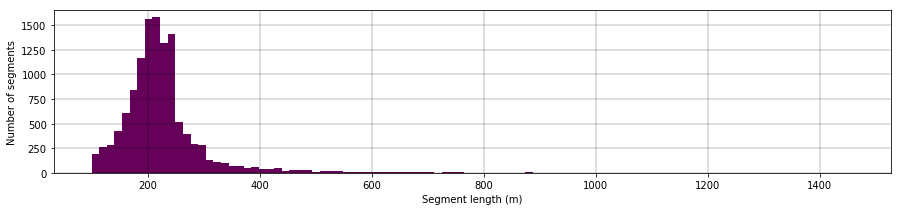

In [25]:
class colour:
    """
    Class defining the global colour variables for all functions.
    
    """
    purple = '#660159'
    grey = '#7f7e7e'
    light_grey = '#777777'
    cmap = 'YlOrRd'
duration_freq = pd.read_sql('''select segment_id, length from congestion.segments_v2''',con)
plt.figure(figsize=(15,3))
plt.hist(duration_freq.length, bins=100, color = colour.purple)
axes = plt.gca()
axes.set_facecolor('xkcd:white')
axes.grid(color='k', linestyle='-', linewidth=0.25)

plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')

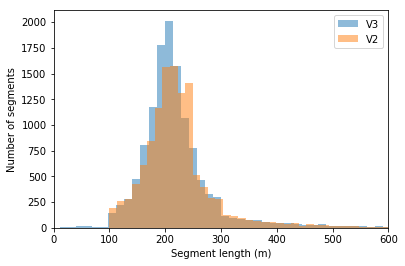

In [27]:
duration_freq1 = pd.read_sql('''select segment_id, length from congestion.segments_v2''',con)
duration_freq = pd.read_sql('''select segment_id, length from congestion.segments_v3''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='V3')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='V2')
plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')
plt.xlim(0, 600)
plt.legend(loc='upper right')
plt.show()


## Best group partitioning

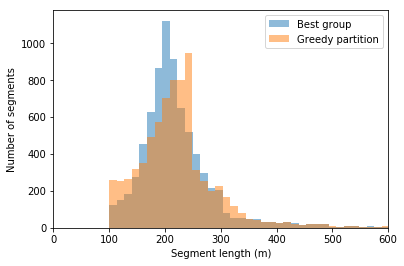

In [20]:
duration_freq1 = pd.read_sql('''select partition_result.* from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_all_possibility)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select * from congestion.partition_all_possibility''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Best group')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy partition')
plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')
plt.xlim(0, 600)
plt.legend(loc='upper right')
plt.show()


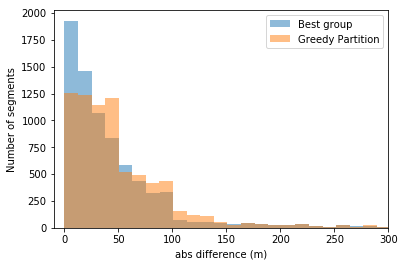

In [21]:
duration_freq1 = pd.read_sql('''select abs(200-partition_result.length) as length from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_all_possibility)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select abs(200-length) as length from congestion.partition_all_possibility''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Best group')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy Partition')
plt.xlabel('abs difference (m)')
plt.ylabel('Number of segments')
plt.xlim(-10, 300)
plt.legend(loc='upper right')
plt.show()

## Simulated Annealing

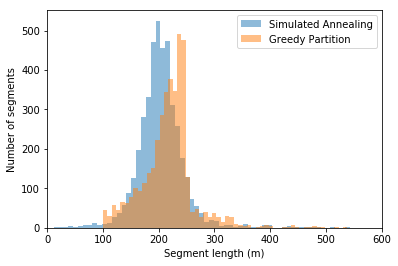

In [22]:
duration_freq1 = pd.read_sql('''select partition_result.* from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_simanneal)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select * from congestion.partition_simanneal''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Simulated Annealing')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy Partition')
plt.xlim(0, 600)
plt.xlabel('Segment length (m)')
plt.ylabel('Number of segments')
plt.legend(loc='upper right')
plt.show()

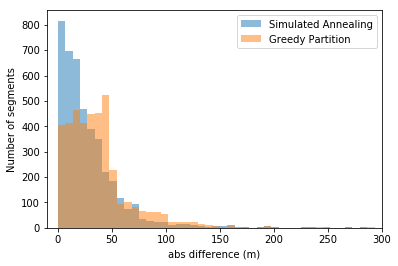

In [23]:
duration_freq1 = pd.read_sql('''select abs(200-partition_result.length) as length from congestion.partition_result inner join  
                                (select distinct segment_id from congestion.partition_simanneal)a 
                                using (segment_id)''',con)
duration_freq = pd.read_sql('''select abs(200-length) as length from congestion.partition_simanneal''',con)
plt.hist(duration_freq.length, 100, alpha=0.5, label='Simulated Annealing')
plt.hist(duration_freq1.length, 100, alpha=0.5, label='Greedy Partition')
plt.xlabel('abs difference (m)')
plt.ylabel('Number of segments')
plt.xlim(-10, 300)
plt.legend(loc='upper right')
plt.show()